In [1]:
import torch
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
from torch import nn, optim 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import cycle
from collections import Counter
%matplotlib inline
import random
from torch.utils import data
import os
from tqdm import tqdm


In [2]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
torch.backends.cudnn.deterministic = True

In [3]:
data_x=pd.read_csv("data_x_new.csv")
data_t=pd.read_csv("data_t_new.csv")
data_xx=pd.read_csv("data_x_x.csv")

In [4]:
h10_x=data_x.iloc[:, [0]]#初值x,t
h10_t=data_x.iloc[:, [1]]
h10_R=data_x.iloc[:,[2]]#初值h实部
h10_C=data_x.iloc[:,[3]]#初值h虚部
hb_x1=data_t.iloc[:,[1]]#边值-5，t
hb_t1=data_t.iloc[:,[0]]
hb_x2=data_t.iloc[:,[2]]#边值5，t
hb_t2=data_t.iloc[:,[0]]

h20_x=data_x.iloc[:, [0]]#初值x,t
h20_t=data_x.iloc[:, [1]]
h20_R=data_x.iloc[:,[4]]#初值h实部
h20_C=data_x.iloc[:,[5]]#初值h虚部

h30_x=data_xx.iloc[:, [0]]
h30_t=data_xx.iloc[:, [1]]
h30_r1=data_xx.iloc[:, [2]]
h30_c1=data_xx.iloc[:, [3]]
h30_r2=data_xx.iloc[:, [4]]
h30_c2=data_xx.iloc[:, [5]]

In [5]:
x = data_x['x']
t = data_t['t']

In [6]:
X, T = np.meshgrid(x,t)

In [7]:
hf= np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

In [8]:
hf_x=hf[:,[0]]
hf_t=hf[:,[1]]

In [9]:
train10_x,test10_x,train10_t,test10_t,train10_r,test10_r,train10_c,test10_c,trainb_x1,testb_x1,trainb_t1,testb_t1,trainb_x2,testb_x2,trainb_t2,testb_t2,train20_r,test20_r,train20_c,test20_c = train_test_split(h10_x,h10_t,h10_R,h10_C,hb_x1,hb_t1,hb_x2,hb_t2,h20_R,h20_C,test_size=0.2)

train30_x,test30_x,train30_t,test30_t,train30_r1,test30_r1,train30_c1,test30_c1,train30_r2,test30_r2,train30_c2,test30_c2=train_test_split(h30_x,h30_t,h30_r1,h30_c1,h30_r2,h30_c2)


In [10]:
trainu_x, testu_x, trainu_t, testu_t = train_test_split(hf_x, hf_t, test_size=0.2)



In [11]:
train10_x=torch.from_numpy(train10_x.to_numpy()).float()
train10_t=torch.from_numpy(train10_t.to_numpy()).float()

train10_r=torch.from_numpy(train10_r.to_numpy()).float()
train10_c=torch.from_numpy(train10_c.to_numpy()).float()

trainb_x1=torch.from_numpy(trainb_x1.to_numpy()).float()
trainb_t1=torch.from_numpy(trainb_t1.to_numpy()).float()
trainb_x2=torch.from_numpy(trainb_x2.to_numpy()).float()
trainb_t2=torch.from_numpy(trainb_t2.to_numpy()).float()

# train20_x=torch.from_numpy(train20_x.to_numpy()).float()
# train20_t=torch.from_numpy(train20_t.to_numpy()).float()
train20_r=torch.from_numpy(train20_r.to_numpy()).float()
train20_c=torch.from_numpy(train20_c.to_numpy()).float()


train30_x=torch.from_numpy(train30_x.to_numpy()).float()
train30_t=torch.from_numpy(train30_t.to_numpy()).float()
train30_r1=torch.from_numpy(train30_r1.to_numpy()).float()
train30_c1=torch.from_numpy(train30_c1.to_numpy()).float()
train30_r2=torch.from_numpy(train30_r2.to_numpy()).float()
train30_c2=torch.from_numpy(train30_c2.to_numpy()).float()

trainu_x=torch.from_numpy(trainu_x).float()
trainu_t=torch.from_numpy(trainu_t).float()

In [12]:
test10_x=torch.from_numpy(test10_x.to_numpy()).float()
test10_t=torch.from_numpy(test10_t.to_numpy()).float()
test10_r=torch.from_numpy(test10_r.to_numpy()).float()
test10_c=torch.from_numpy(test10_c.to_numpy()).float()

testb_x1=torch.from_numpy(testb_x1.to_numpy()).float()
testb_t1=torch.from_numpy(testb_t1.to_numpy()).float()
testb_x2=torch.from_numpy(testb_x2.to_numpy()).float()
testb_t2=torch.from_numpy(testb_t2.to_numpy()).float()

# test20_x=torch.from_numpy(test20_x.to_numpy()).float()
# test20_t=torch.from_numpy(test20_t.to_numpy()).float()
test20_r=torch.from_numpy(test20_r.to_numpy()).float()
test20_c=torch.from_numpy(test20_c.to_numpy()).float()

testu_x=torch.from_numpy(testu_x).float()
testu_t=torch.from_numpy(testu_t).float()

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [14]:
class DNN(torch.nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 4)
        )

    def forward(self, x):
        return self.net(x)

In [15]:
class PhysicsInformedNN():
    def __init__(self, u10_x, u10_t, u10_r, u10_c, ub_x1, ub_t1, ub_x2, ub_t2, u20_r, u20_c, uf_x, uf_t,u30_x,u30_t,u30_r1,u30_c1,u30_r2,u30_c2):
        self.u10_x = torch.tensor(u10_x, requires_grad=True).float().to(device)
        self.u10_t = torch.tensor(u10_t, requires_grad=True).float().to(device)
        self.u10_r = torch.tensor(u10_r, requires_grad=True).float().to(device)
        self.u10_c = torch.tensor(u10_c, requires_grad=True).float().to(device)
        
        self.ub_x1 = torch.tensor(ub_x1, requires_grad=True).float().to(device)
        self.ub_x2 = torch.tensor(ub_x2, requires_grad=True).float().to(device)
        self.ub_t1 = torch.tensor(ub_t1, requires_grad=True).float().to(device)
        self.ub_t2 = torch.tensor(ub_t2, requires_grad=True).float().to(device)
        
#         self.u20_x = u20_x.clone().detach().requires_grad_(True).float().to(device)
#         self.u20_t = torch.tensor(u20_t, requires_grad=True).float().to(device)
        self.u20_r = torch.tensor(u20_r, requires_grad=True).float().to(device)
        self.u20_c = torch.tensor(u20_c, requires_grad=True).float().to(device)
        
        self.u30_x = torch.tensor(u30_x, requires_grad=True).float().to(device)
        self.u30_t = torch.tensor(u30_t, requires_grad=True).float().to(device)
        self.u30_r1 = torch.tensor(u30_r1, requires_grad=True).float().to(device)
        self.u30_c1 = torch.tensor(u30_c1, requires_grad=True).float().to(device)
        self.u30_r2 = torch.tensor(u30_r2, requires_grad=True).float().to(device)
        self.u30_c2 = torch.tensor(u30_c2, requires_grad=True).float().to(device)
      
        
        self.uf_x = torch.tensor(uf_x,requires_grad=True).float().to(device)
        self.uf_t = torch.tensor(uf_t,requires_grad=True).float().to(device)
        
        self.lambda_1 = torch.tensor([0.9], requires_grad=True).to(device)
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        
        self.lambda_2 = torch.tensor([2.3], requires_grad=True).to(device)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        self.dnn = DNN().to(device)
        self.optimizer = torch.optim.Adam([
            {'params':self.dnn.parameters()},
            {'params': [self.lambda_1], 'lr': 0.000206},
            {'params': [self.lambda_2], 'lr': 0.000105}
        ],lr=0.012 )
        
        self.iter = 0
    
        self.losshistory=[]
    def net_u(self, x, t):  
        u1 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,0],1)
        v1 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,1],1)
        u2 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,2],1)
        v2 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,3],1)
        return u1, v1, u2, v2

    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        beta=1
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        lambda_3 = -1
        lambda_4 = 0
        u1, v1,u2, v2= self.net_u(x, t)
        
        u1_t = torch.autograd.grad(
            u1, t, 
            grad_outputs=torch.ones_like(u1),
            retain_graph=True,
            create_graph=True
        )[0]
        u1_x = torch.autograd.grad(
            u1, x, 
            grad_outputs=torch.ones_like(u1),
            retain_graph=True,
            create_graph=True
        )[0]
        u1_xx = torch.autograd.grad(
            u1_x, x, 
            grad_outputs=torch.ones_like(u1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v1_t = torch.autograd.grad(
            v1, t, 
            grad_outputs=torch.ones_like(v1),
            retain_graph=True,
            create_graph=True
        )[0]
        v1_x = torch.autograd.grad(
            v1, x, 
            grad_outputs=torch.ones_like(v1),
            retain_graph=True,
            create_graph=True
        )[0]
        v1_xx = torch.autograd.grad(
            v1_x, x, 
            grad_outputs=torch.ones_like(v1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        
        u2_t = torch.autograd.grad(
            u2, t, 
            grad_outputs=torch.ones_like(u2),
            retain_graph=True,
            create_graph=True
        )[0]
        u2_x = torch.autograd.grad(
            u2, x, 
            grad_outputs=torch.ones_like(u2),
            retain_graph=True,
            create_graph=True
        )[0]
        u2_xx = torch.autograd.grad(
            u2_x, x, 
            grad_outputs=torch.ones_like(u2_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v2_t = torch.autograd.grad(
            v2, t, 
            grad_outputs=torch.ones_like(v2),
            retain_graph=True,
            create_graph=True
        )[0]
        v2_x = torch.autograd.grad(
            v2, x, 
            grad_outputs=torch.ones_like(v2),
            retain_graph=True,
            create_graph=True
        )[0]
        v2_xx = torch.autograd.grad(
            v2_x, x, 
            grad_outputs=torch.ones_like(v2_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f_u1 = (
            v1_t + u1_xx
        + lambda_1*u1*(u1**2 + v1**2) + lambda_2*u1*(u2**2 + v2**2) + lambda_3*(u1*(u2**2 - v2**2) + 2*u2*v1*v2) + lambda_4*(u2*(u1**2 - v1**2) + 2*u1*v1*v2)
    )

        f_v1 = (
                -u1_t + v1_xx
            + lambda_1*v1*(u1**2 + v1**2) + lambda_2*v1*(u2**2 + v2**2) - lambda_3*(v1*(u2**2 - v2**2) - 2*u1*u2*v2) - lambda_4*(v2*(u1**2 - v1**2) - 2*u1*u2*v1)
        )

        f_u2 = (
                v2_t + beta*u2_xx
            + lambda_1*u2*(u2**2 + v2**2) + lambda_2*u2*(u1**2 + v1**2) + lambda_3*(u2*(u1**2 - v1**2) + 2*u1*v2*v1) + lambda_4*(u1*(u2**2 - v2**2) + 2*u2*v2*v1)
        )

        f_v2 = (
                -u2_t + beta*v2_xx
            + lambda_1*v2*(u2**2 + v2**2) + lambda_2*v2*(u1**2 + v1**2) - lambda_3*(v2*(u1**2 - v1**2) - 2*u2*u1*v1) - lambda_4*(v1*(u2**2 - v2**2) - 2*u2*u1*v2)
        )
        a=u1_x
        b=v1_x
        c=u2_x
        d=v2_x
        return f_u1, f_v1, f_u2, f_v2, a, b, c, d
     
    def loss_func(self):
        for self.iter in tqdm(range(20000)):
            torch.cuda.empty_cache()
            self.optimizer.zero_grad()

            u10_pred, v10_pred, u20_pred, v20_pred = self.net_u(self.u10_x,self.u10_t)
            u30_pred1, v30_pred1, u30_pred2, v30_pred2 = self.net_u(self.u30_x,self.u30_t)
            u1b_pred1, v1b_pred1, u2b_pred1, v2b_pred1 = self.net_u(self.ub_x1,self.ub_t1)
            u1b_pred2, v1b_pred2, u2b_pred2, v2b_pred2 = self .net_u(self.ub_x2,self.ub_t2)
            
            
            a1,b1,c1,d1,u1bx_pred1, v1bx_pred1,u2bx_pred1, v2bx_pred1 = self.net_f(self.ub_x1,self.ub_t1)
            a2,b2,c2,d2,u1bx_pred2, v1bx_pred2,u2bx_pred2, v2bx_pred2 = self.net_f(self.ub_x2,self.ub_t2)
            
            f_predu1, f_predv1, f_predu2, f_predv2,a1,b1,c1,d1 = self.net_f(self.uf_x,self.uf_t)
            
            loss_u0 = torch.mean((self.u10_r - u10_pred) ** 2)+torch.mean((self.u10_c - v10_pred) ** 2)+torch.mean((self.u20_r - u20_pred) ** 2)+torch.mean((self.u20_c - v20_pred) ** 2)
            loss_ub = torch.mean((u1b_pred1 - u1b_pred2) ** 2)+torch.mean((v1b_pred1 - v1b_pred2) ** 2)+torch.mean((u2b_pred1 - u2b_pred2) ** 2)+torch.mean((v2b_pred1 - v2b_pred2) ** 2)
            loss_ubx = torch.mean((u1bx_pred1 - u1bx_pred2) ** 2)+torch.mean((v1bx_pred1 - v1bx_pred2) ** 2)+torch.mean((u2bx_pred1 - u2bx_pred2) ** 2)+torch.mean((v2bx_pred1 - v2bx_pred2) ** 2)
            loss_f = torch.mean(f_predu1 ** 2)+torch.mean(f_predv1 ** 2)+torch.mean(f_predu2 ** 2)+torch.mean(f_predv2 ** 2)
            loss_u1=torch.mean((self.u30_r1 - u30_pred1) ** 2)+torch.mean((self.u30_c1 - v30_pred1) ** 2)+torch.mean((self.u30_r2 - u30_pred2) ** 2)+torch.mean((self.u30_c2 - v30_pred2) ** 2)
            
            loss = loss_f+loss_u0 + loss_ub + loss_ubx+loss_u1
            
            loss.backward()
            self.optimizer.step()
            
            self.losshistory.append(loss.clone().detach().cpu())
            
            self.iter += 1
            with torch.no_grad():
                if self.iter % 500 == 0:
                    print('Iter %d, Loss: %.5e, Loss_u0: %.5e, Loss_ub: %.5e, Loss_ubx: %.5e, Loss_f: %.5e, Loss_u1: %.5e, lambda1: %.5e, lambda2: %.5e' % (self.iter, loss.item(), loss_u0.item(), loss_ub.item(), loss_ubx.item(), loss_f.item(), loss_u1.item(), self.lambda_1,self.lambda_2))
        return float(loss)
        
 
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
        
    def predict1(self, X, Y):
        x = torch.tensor(X, requires_grad=True).float().to(device)
        t = torch.tensor(Y, requires_grad=True).float().to(device)

        self.dnn.eval()
        u1, v1 , u2, v2= self.net_u(x, t)
        u1 = u1.detach().cpu().numpy()
        v1 = v1.detach().cpu().numpy()
        u2 = u2.detach().cpu().numpy()
        v2 = v2.detach().cpu().numpy()
        return u1, v1, u2, v2
    
    def predict2(self, X, Y):
        x = torch.tensor(X, requires_grad=True).float().to(device)
        t = torch.tensor(Y, requires_grad=True).float().to(device)

        self.dnn.eval()
        f1, f2, f3, f4, a, b, c, d = self.net_f(x, t)
        f1 = f1.detach().cpu().numpy()
        f2 = f2.detach().cpu().numpy()
        f3 = f3.detach().cpu().numpy()
        f4 = f4.detach().cpu().numpy()
        return  f1, f2, f3, f4, a, b, c, d

In [16]:


model = PhysicsInformedNN(train10_x, train10_t, train10_r, train10_c, 
                          trainb_x1, trainb_t1, trainb_x2, trainb_t2,
                        train20_r, train20_c, trainu_x, trainu_t,
                         train30_x,train30_t, train30_r1, train30_c1,train30_r2,train30_c2)




C:\Users\npofsi\AppData\Local\Temp\ipykernel_19900\2281346290.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_x = torch.tensor(u10_x, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_19900\2281346290.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_t = torch.tensor(u10_t, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_19900\2281346290.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_r = torch.tensor(u10_r, requires_grad=True).float

In [17]:
%%time
model.losshistory=[]            
model.train()

  2%|▎         | 500/20000 [01:43<1:00:11,  5.40it/s]

Iter 500, Loss: 1.42629e-01, Loss_u0: 1.40969e-02, Loss_ub: 1.93318e-05, Loss_ubx: 2.80924e-05, Loss_f: 3.59358e-02, Loss_u1: 9.25493e-02, lambda1: 9.62413e-01, lambda2: 2.27511e+00


  5%|▌         | 1001/20000 [03:19<59:13,  5.35it/s] 

Iter 1000, Loss: 1.30046e-01, Loss_u0: 1.04679e-02, Loss_ub: 3.35914e-05, Loss_ubx: 4.71676e-05, Loss_f: 3.44926e-02, Loss_u1: 8.50046e-02, lambda1: 9.93006e-01, lambda2: 2.24109e+00


  8%|▊         | 1500/20000 [04:56<56:25,  5.47it/s]  

Iter 1500, Loss: 1.00198e-01, Loss_u0: 3.02101e-03, Loss_ub: 8.52247e-06, Loss_ubx: 1.17664e-05, Loss_f: 2.76775e-02, Loss_u1: 6.94791e-02, lambda1: 1.00855e+00, lambda2: 2.21445e+00


 10%|█         | 2001/20000 [06:31<57:10,  5.25it/s]  

Iter 2000, Loss: 9.23980e-02, Loss_u0: 1.98133e-03, Loss_ub: 1.14429e-04, Loss_ubx: 7.01079e-06, Loss_f: 2.11555e-02, Loss_u1: 6.91397e-02, lambda1: 1.00926e+00, lambda2: 2.20352e+00


 13%|█▎        | 2501/20000 [08:08<58:30,  4.99it/s]  

Iter 2500, Loss: 1.70765e-01, Loss_u0: 6.63618e-03, Loss_ub: 2.37114e-04, Loss_ubx: 2.57736e-05, Loss_f: 5.69292e-02, Loss_u1: 1.06937e-01, lambda1: 1.00914e+00, lambda2: 2.19436e+00


 15%|█▌        | 3001/20000 [09:44<57:07,  4.96it/s]  

Iter 3000, Loss: 7.66292e-02, Loss_u0: 1.33913e-03, Loss_ub: 1.78104e-05, Loss_ubx: 8.38572e-06, Loss_f: 1.63932e-02, Loss_u1: 5.88707e-02, lambda1: 1.00100e+00, lambda2: 2.18547e+00


 18%|█▊        | 3501/20000 [11:20<53:39,  5.12it/s]

Iter 3500, Loss: 1.43260e-01, Loss_u0: 7.51115e-03, Loss_ub: 7.77522e-06, Loss_ubx: 8.15555e-06, Loss_f: 3.52724e-02, Loss_u1: 1.00460e-01, lambda1: 1.01936e+00, lambda2: 2.17605e+00


 20%|██        | 4001/20000 [12:57<50:11,  5.31it/s]

Iter 4000, Loss: 1.07845e-01, Loss_u0: 2.20442e-03, Loss_ub: 1.70665e-06, Loss_ubx: 1.90849e-06, Loss_f: 2.86345e-02, Loss_u1: 7.70025e-02, lambda1: 1.03003e+00, lambda2: 2.14863e+00


 23%|██▎       | 4501/20000 [14:33<48:35,  5.32it/s]

Iter 4500, Loss: 1.15131e-01, Loss_u0: 4.57430e-03, Loss_ub: 1.58557e-06, Loss_ubx: 1.23533e-06, Loss_f: 4.34896e-02, Loss_u1: 6.70645e-02, lambda1: 1.03407e+00, lambda2: 2.12760e+00


 25%|██▌       | 5001/20000 [16:09<47:49,  5.23it/s]

Iter 5000, Loss: 7.98843e-02, Loss_u0: 1.41881e-03, Loss_ub: 1.83789e-06, Loss_ubx: 2.38366e-06, Loss_f: 1.87766e-02, Loss_u1: 5.96847e-02, lambda1: 1.02607e+00, lambda2: 2.11523e+00


 28%|██▊       | 5500/20000 [17:44<46:38,  5.18it/s]

Iter 5500, Loss: 6.62154e-02, Loss_u0: 1.30027e-03, Loss_ub: 1.40961e-07, Loss_ubx: 3.41181e-07, Loss_f: 1.82682e-02, Loss_u1: 4.66464e-02, lambda1: 1.01434e+00, lambda2: 2.10221e+00


 30%|███       | 6001/20000 [19:20<45:13,  5.16it/s]

Iter 6000, Loss: 2.19528e-01, Loss_u0: 9.68309e-03, Loss_ub: 4.55952e-05, Loss_ubx: 2.62524e-05, Loss_f: 4.48090e-02, Loss_u1: 1.64964e-01, lambda1: 1.00813e+00, lambda2: 2.09466e+00


 32%|███▎      | 6500/20000 [20:56<43:20,  5.19it/s]

Iter 6500, Loss: 1.08776e-01, Loss_u0: 2.64823e-03, Loss_ub: 7.24582e-07, Loss_ubx: 1.28937e-06, Loss_f: 2.44297e-02, Loss_u1: 8.16964e-02, lambda1: 1.03080e+00, lambda2: 2.09292e+00


 35%|███▌      | 7001/20000 [22:32<41:59,  5.16it/s]

Iter 7000, Loss: 1.09322e-01, Loss_u0: 1.84795e-03, Loss_ub: 5.19839e-07, Loss_ubx: 1.17404e-06, Loss_f: 2.61531e-02, Loss_u1: 8.13191e-02, lambda1: 1.03580e+00, lambda2: 2.08066e+00


 38%|███▊      | 7501/20000 [24:08<39:09,  5.32it/s]

Iter 7500, Loss: 8.48196e-02, Loss_u0: 2.35427e-03, Loss_ub: 2.26548e-07, Loss_ubx: 3.06794e-07, Loss_f: 2.71458e-02, Loss_u1: 5.53190e-02, lambda1: 1.03398e+00, lambda2: 2.06799e+00


 40%|████      | 8001/20000 [25:44<39:07,  5.11it/s]

Iter 8000, Loss: 6.66019e-02, Loss_u0: 1.46261e-03, Loss_ub: 2.69386e-07, Loss_ubx: 1.77969e-07, Loss_f: 1.90260e-02, Loss_u1: 4.61128e-02, lambda1: 1.02820e+00, lambda2: 2.05360e+00


 42%|████▎     | 8500/20000 [27:19<38:45,  4.94it/s]

Iter 8500, Loss: 5.42747e-01, Loss_u0: 1.92124e-01, Loss_ub: 2.73856e-15, Loss_ubx: 2.62149e-14, Loss_f: 7.22264e-02, Loss_u1: 2.78396e-01, lambda1: 9.98875e-01, lambda2: 2.04994e+00


 45%|████▌     | 9001/20000 [28:57<35:09,  5.21it/s]

Iter 9000, Loss: 2.80237e-01, Loss_u0: 2.05255e-02, Loss_ub: 6.00371e-14, Loss_ubx: 3.67171e-13, Loss_f: 4.63051e-02, Loss_u1: 2.13406e-01, lambda1: 9.81481e-01, lambda2: 2.04927e+00


 48%|████▊     | 9500/20000 [31:30<1:10:11,  2.49it/s]

Iter 9500, Loss: 2.01733e-01, Loss_u0: 4.70708e-03, Loss_ub: 4.97170e-07, Loss_ubx: 1.19199e-07, Loss_f: 3.07869e-02, Loss_u1: 1.66239e-01, lambda1: 9.91483e-01, lambda2: 2.06692e+00


 50%|█████     | 10001/20000 [33:43<32:41,  5.10it/s] 

Iter 10000, Loss: 1.71732e-01, Loss_u0: 2.70696e-03, Loss_ub: 2.37177e-15, Loss_ubx: 3.65177e-14, Loss_f: 2.32348e-02, Loss_u1: 1.45791e-01, lambda1: 1.01428e+00, lambda2: 2.08235e+00


 52%|█████▎    | 10500/20000 [37:17<1:08:17,  2.32it/s]

Iter 10500, Loss: 1.57445e-01, Loss_u0: 5.29581e-03, Loss_ub: 7.85772e-07, Loss_ubx: 1.11748e-06, Loss_f: 4.64661e-02, Loss_u1: 1.05681e-01, lambda1: 1.02740e+00, lambda2: 2.08630e+00


 55%|█████▌    | 11000/20000 [40:41<1:01:29,  2.44it/s]

Iter 11000, Loss: 6.63316e-01, Loss_u0: 3.48716e-01, Loss_ub: 0.00000e+00, Loss_ubx: 1.61787e-20, Loss_f: 1.01335e-02, Loss_u1: 3.04466e-01, lambda1: 1.03320e+00, lambda2: 2.08899e+00


 57%|█████▊    | 11500/20000 [44:21<1:08:01,  2.08it/s]

Iter 11500, Loss: 6.96878e-01, Loss_u0: 3.86806e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.60738e-03, Loss_u1: 3.08465e-01, lambda1: 1.03344e+00, lambda2: 2.08910e+00


 60%|██████    | 12000/20000 [48:04<46:33,  2.86it/s]  

Iter 12000, Loss: 6.88636e-01, Loss_u0: 3.79656e-01, Loss_ub: 9.30096e-06, Loss_ubx: 9.80042e-06, Loss_f: 3.76257e-03, Loss_u1: 3.05199e-01, lambda1: 1.03366e+00, lambda2: 2.08979e+00


 62%|██████▎   | 12500/20000 [51:46<1:01:39,  2.03it/s]

Iter 12500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.40392e-06, Loss_u1: 3.11696e-01, lambda1: 1.03367e+00, lambda2: 2.08980e+00


 65%|██████▌   | 13000/20000 [54:35<34:45,  3.36it/s]  

Iter 13000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.40393e-06, Loss_u1: 3.11696e-01, lambda1: 1.03367e+00, lambda2: 2.08980e+00


 68%|██████▊   | 13500/20000 [58:06<47:47,  2.27it/s]  

Iter 13500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.40381e-06, Loss_u1: 3.11696e-01, lambda1: 1.03362e+00, lambda2: 2.08980e+00


 70%|███████   | 14000/20000 [1:01:45<34:46,  2.88it/s]  

Iter 14000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.40366e-06, Loss_u1: 3.11696e-01, lambda1: 1.03356e+00, lambda2: 2.08980e+00


 72%|███████▎  | 14500/20000 [1:05:25<48:23,  1.89it/s]  

Iter 14500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.40350e-06, Loss_u1: 3.11696e-01, lambda1: 1.03350e+00, lambda2: 2.08980e+00


 75%|███████▌  | 15000/20000 [1:08:37<20:26,  4.08it/s]

Iter 15000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.40334e-06, Loss_u1: 3.11696e-01, lambda1: 1.03344e+00, lambda2: 2.08980e+00


 78%|███████▊  | 15500/20000 [1:11:34<18:41,  4.01it/s]

Iter 15500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.40313e-06, Loss_u1: 3.11696e-01, lambda1: 1.03336e+00, lambda2: 2.08980e+00


 80%|████████  | 16000/20000 [1:13:38<16:26,  4.06it/s]

Iter 16000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.40282e-06, Loss_u1: 3.11696e-01, lambda1: 1.03324e+00, lambda2: 2.08980e+00


 82%|████████▎ | 16500/20000 [1:15:42<14:17,  4.08it/s]

Iter 16500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.40245e-06, Loss_u1: 3.11696e-01, lambda1: 1.03311e+00, lambda2: 2.08980e+00


 85%|████████▌ | 17000/20000 [1:17:44<11:59,  4.17it/s]

Iter 17000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.40197e-06, Loss_u1: 3.11696e-01, lambda1: 1.03293e+00, lambda2: 2.08980e+00


 88%|████████▊ | 17500/20000 [1:19:48<09:29,  4.39it/s]

Iter 17500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.40134e-06, Loss_u1: 3.11696e-01, lambda1: 1.03269e+00, lambda2: 2.08980e+00


 90%|█████████ | 18000/20000 [1:21:50<08:40,  3.84it/s]

Iter 18000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.40052e-06, Loss_u1: 3.11696e-01, lambda1: 1.03239e+00, lambda2: 2.08980e+00


 92%|█████████▎| 18500/20000 [1:23:58<06:20,  3.94it/s]

Iter 18500, Loss: 6.98658e-01, Loss_u0: 3.86985e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.38983e-06, Loss_u1: 3.11672e-01, lambda1: 1.03200e+00, lambda2: 2.08980e+00


 95%|█████████▌| 19000/20000 [1:26:04<04:20,  3.83it/s]

Iter 19000, Loss: 6.98659e-01, Loss_u0: 3.86962e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.39788e-06, Loss_u1: 3.11695e-01, lambda1: 1.03151e+00, lambda2: 2.08980e+00


 98%|█████████▊| 19500/20000 [1:28:12<01:56,  4.29it/s]

Iter 19500, Loss: 6.98658e-01, Loss_u0: 3.86973e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.39165e-06, Loss_u1: 3.11684e-01, lambda1: 1.03087e+00, lambda2: 2.08980e+00


100%|██████████| 20000/20000 [1:30:19<00:00,  3.69it/s]

Iter 20000, Loss: 6.98658e-01, Loss_u0: 3.86950e-01, Loss_ub: 0.00000e+00, Loss_ubx: 0.00000e+00, Loss_f: 1.39788e-06, Loss_u1: 3.11706e-01, lambda1: 1.03006e+00, lambda2: 2.08980e+00
Wall time: 1h 30min 19s


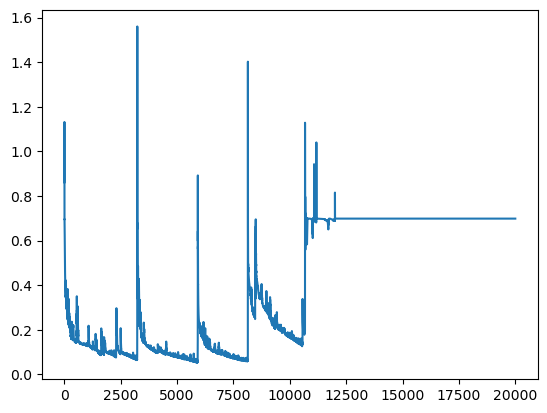

In [18]:
plt.plot(model.losshistory)

In [19]:
u00_1, v00_1, u00_2, v00_2 = model.predict1(test10_x,test10_t)
u11_1, v11_1, u11_2, v11_2 = model.predict1(testb_x1,testb_t1)
u22_1, v22_1, u22_2, v22_2 = model.predict1(testb_x2,testb_t2)
a1,b1,c1,d1, ux11_1, vx11_1, ux11_2, vx11_2 = model.predict2(testb_x1,testb_t1)
a1,b1,c1,d1, ux22_1, vx22_1, ux22_2, vx22_2 = model.predict2(testb_x2,testb_t2)

f1, f2, f3, f4,a1,b1,c1,d1 = model.predict2(testu_x,testu_t)     

C:\Users\npofsi\AppData\Local\Temp\ipykernel_19900\2281346290.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_19900\2281346290.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(Y, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_19900\2281346290.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X, requires_grad=True).float().to(device)
C:\Users\npofsi\App

In [20]:
error_u0= ((np.linalg.norm(test10_r - u00_1, 2))**2+(np.linalg.norm(test10_c - v00_1, 2))**2+(np.linalg.norm(test20_r - u00_2, 2))**2+(np.linalg.norm(test20_c - v00_2, 2))**2)/20
error_ub= ((np.linalg.norm(u11_1 - u22_1, 2))**2+(np.linalg.norm(v11_1 - v22_1, 2))**2+(np.linalg.norm(u11_1 - u22_1, 2))**2+(np.linalg.norm(v11_1 - v22_1, 2))**2)/20
error_ubx= (
    (np.linalg.norm(ux11_1.cpu().detach().numpy() - ux22_1.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(vx11_1.cpu().detach().numpy() - vx22_1.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(ux11_2.cpu().detach().numpy() - ux22_2.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(vx11_2.cpu().detach().numpy() - vx22_2.cpu().detach().numpy(), 2))**2)/20

error_f= ((np.linalg.norm(f1, 2))**2+(np.linalg.norm(f2, 2))**2+(np.linalg.norm(f1, 2))**2+(np.linalg.norm(f2, 2))**2)/2000
print('Error_u0: %.5e, Error_ub: %.5e, Error_ubx: %.5e, Error_f: %.5e' % (error_u0.item(), error_ub.item(), error_ubx.item(), error_f.item()))




Error_u0: 3.74156e-01, Error_ub: 0.00000e+00, Error_ubx: 0.00000e+00, Error_f: 2.74209e-06
